# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os

In [3]:
import tests

In [4]:
RANDOM_STATE = 2020

In [5]:
def p(color="", bold=0):
    color = color.lower().replace(" ", "")
    if color == "black" or color == "":
        color = "\033[0m"
    elif color == "green" or color == "g":
        color = "\033[92m"
    elif color == "gray" or color == "gr":
        color = "\033[90m"
    elif color == "red" or color == "r":
        color = "\033[91m"
    elif color == "blue" or color == "b":
        color = "\033[94m"
    else:
        color = ""
    
    if bold == 1:
        color += "\033[1m"

    return (color)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [6]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [8]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return (0)
    
    return (1 - sum((np.unique(x, return_counts=True)[1] / len(x)) ** 2))

In [9]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [10]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    gain = gini_index(parent_node) - \
            sum([gini_index(child) * len(child) / len(parent_node) for child in splits])
    
    return(gain)

In [11]:
tests.test_gini_gain(gini_gain)

 All good!


### Entropy

0.5 points for *entropy* function. WARNING! Use only natural logarithm np.log() for calculation.

In [12]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.
    data = np.unique(x, return_counts=True)[1] / len(x)
    return(sum(-data * np.log(data)))

In [13]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [14]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    gain = entropy(parent_node) - \
            sum([entropy(child) * len(child) / len(parent_node) for child in splits])
    
    return(gain)

In [15]:
tests.test_information_gain(information_gain)

 All good!


## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen threshold are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [16]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    X_column = X[:, column].copy()
    left_mask = X_column < value
    right_mask = X_column >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    
    return left_X, right_X, left_y, right_y

In [17]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

In [18]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """
    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None           # value of the next split
        self.column_index = None        # column to use for the next split
        self.outcome_probs = None       # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.rng = random_gen if random_gen is not None else np.random.default_rng(RANDOM_STATE)

    @property
    def is_terminal(self):
        """Define is it terminal node."""          
        return not bool(self.left_child and self.right_child)
    
    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.rng.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain
    
    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        # 3 points
        
        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and max_depth == 0:
            return(self._compute_outcome(y))
        
        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(X.shape[1] * feature_frac)
        
        # Find the next split    
        column, value, gain = self._find_best_split(X, y, n_features)
        
        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or gain == 0:
            self._compute_outcome(y)
            return
        
        # Save the necessary information about the next split
        self.threshold = value
        self.column_index = column
        
        # Reduce the max_depth parameter for the next tree
        if max_depth is not None:
            max_depth = max_depth - 1

        # Split dataset
        left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results 
        self.left_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.left_child.fit(left_X, left_target, feature_frac=feature_frac, max_depth=max_depth)

        self.right_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.right_child.fit(right_X, right_target, feature_frac=feature_frac, max_depth=max_depth)

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points
        
        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[self.column_index] < self.threshold:
                return(self.left_child.predict_row(row))
            else:
                return(self.right_child.predict_row(row))

        return(self.outcome_probs)

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """ 
        # 1 point
        
        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(X.shape[0])
        # Go through all rows of the dataset
        for i in range(X.shape[0]):
            # Save the prediction for the current row
            result[i] = self.predict_row(X[i])
        return result

In [19]:
tests.test_tree(Tree)

 All good!


**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

*****
### `КОММЕНТАРИЙ`
>Нет явных указания на то какой метод (criterion= "gini" или "entropy") использовать. Посмотрим на оба.
>
>Перед заданием №1 мы уже сделали разбмение на **X_train, X_test, y_train, y_test**
*****


In [20]:
# Your code here
def tree_with_two_criterion(max_depth=1):
    criterions = ["gini", "entropy"]
    print(f"{p('gray')}_____________________________________________________{p()}")
    print(f"Формируем решающие деревья с параметром {p('b',1)}max_depth={max_depth}{p()}")
    for criterion in criterions:
        model = Tree(criterion=criterion, random_gen=np.random.default_rng(RANDOM_STATE))
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_score = round(accuracy_score(y_train, model.predict(X_train.to_numpy())), 3)
        test_score = round(accuracy_score(y_test, model.predict(X_test.to_numpy())), 3)
        print(f"   Используемый критерий [{p('b',1)}{criterion}{p()}]")
        print(f"   Полученные оценки:")
        print(f"      на обучающей выборке: {p('b',1)}{train_score}{p()}")
        print(f"      на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

In [21]:
# Your code here
tree_with_two_criterion(3)
tree_with_two_criterion(None)

_____________________________________________________
Формируем решающие деревья с параметром max_depth=3
   Используемый критерий [gini]
   Полученные оценки:
      на обучающей выборке: 0.928
      на тестовой выборке:  0.667

   Используемый критерий [entropy]
   Полученные оценки:
      на обучающей выборке: 0.873
      на тестовой выборке:  0.738

_____________________________________________________
Формируем решающие деревья с параметром max_depth=None
   Используемый критерий [gini]
   Полученные оценки:
      на обучающей выборке: 1.0
      на тестовой выборке:  0.643

   Используемый критерий [entropy]
   Полученные оценки:
      на обучающей выборке: 1.0
      на тестовой выборке:  0.714



*****
### `КОММЕНТАРИЙ`
У нас не было указания на то, какой метод оценки ("gini" или "entropy") использовать, а значит надо сформулировать пояснений различий результатов между разными значениями **max_depth**, а не методами.

Отличие **max_depth=3** и **max_depth=None** заключается в том, что во втором случае алгоритм заканчивает "формирование" дерева, когда доходит до последнего возможного деления - далее уже нет возможности разделить node на части. Это приводит к переобучености для обучающей выборки, что мы и видим когда accuracy становится равным 1.0, но, в нашем случае, может дать, а может и не дать более качественный результат и на тестовой выборке.

Но что "хорошо" для обучающей выборки, "плохо" для тестовой - для "настроенного" на обучающую выборку дерева, результат на тестовой выборке становится хуже.

*****


In [22]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in range(0, 8):
        max_depths.append(max_depth)
        model = Tree(criterion=criterion, random_gen=np.random.default_rng(RANDOM_STATE))
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize':(16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

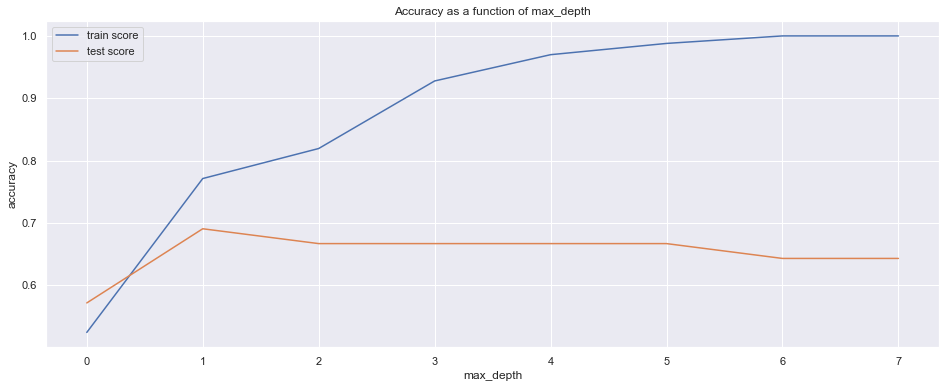

In [23]:
plot_metrics_on_depths('gini')

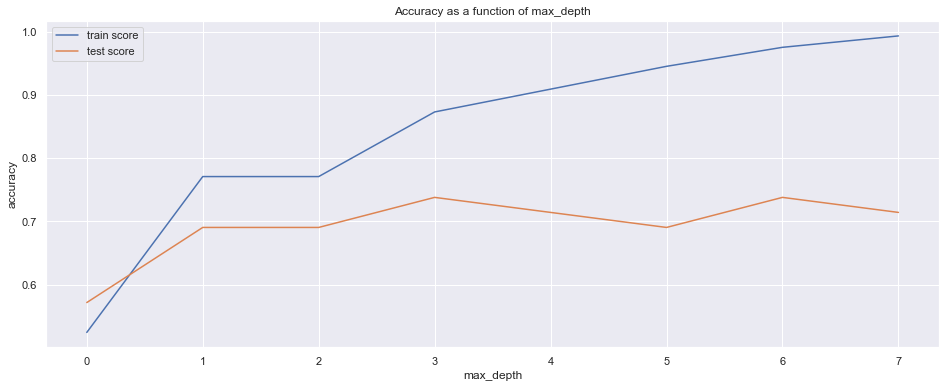

In [24]:
plot_metrics_on_depths('entropy')

## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [25]:
class RandomForestClassifier(BaseEstimator, ClassifierMixin):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None, 
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac
        
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        
        self.random_gen = random_gen

    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return self.random_gen.integers(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points
        
        self.set_params(n_estimators=self.n_estimators,
                        max_depth=self.max_depth,
                        feature_frac=self.feature_frac,
                        criterion=self.criterion,
                        bootstrap=self.bootstrap,
                        random_gen=self.random_gen,
                       )

        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
            
        self._init_data(X, y)
        
        # Iterate over all trees in the forest
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            # Fit the tree
            tree.fit(X, y, self.feature_frac, self.max_depth)

        return self
        
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = np.zeros(X.shape[0])
            # Go through all rows of the dataset
            for i in range(X.shape[0]):
                # Initialize a counter for voting
                row_pred = []
                # Sum up predictions from all the voters
                for tree in self.trees:
                    row_pred.append(tree.predict_row(X[i]))
                # Compute the mean of the votes
                row_pred = np.mean(row_pred)
                # Save the rounded value as the prediction for the current row
                predictions[i] = np.round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

    def score(self, X, y=None):
        return (accuracy_score(y, self.predict(X)))
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        
        if self.criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {self.criterion}')
        
        self.random_gen = self.random_gen if self.random_gen is not None else np.random.default_rng(RANDOM_STATE)
        self.trees = [Tree(criterion=self.criterion, random_gen=self.random_gen) for _ in range(self.n_estimators)]

        return self

    def get_params(self, deep=True):
        ret_dict = {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "bootstrap": self.bootstrap,
            "feature_frac": self.feature_frac,
            "random_gen": self.random_gen,
        }
        return ret_dict

In [26]:
tests.test_random_forest(RandomForestClassifier)

 All good!


**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

In [27]:
# Your code here
def random_forest_with_two_criterion(n_estimators=1,
                                     max_depth=None,
                                     feature_frac=None,
                                     bootstrap=True):

    criterions = ["gini", "entropy"]
    print(f"{p('gray')}_____________________________________________________{p()}")
    print(f"Формируем 'случайный лес' с параметром {p('b',1)}n_estimators={n_estimators}{p()}")
    for criterion in criterions:
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       feature_frac=feature_frac,
                                       criterion=criterion,
                                       bootstrap=bootstrap,
                                       random_gen=np.random.default_rng(RANDOM_STATE)
                                      )
        model.fit(X_train.values, y_train.values)
        train_score = round(accuracy_score(y_train, model.predict(X_train.to_numpy())), 3)
        test_score = round(accuracy_score(y_test, model.predict(X_test.to_numpy())), 3)
        print(f"   Используемый критерий [{p('b',1)}{criterion}{p()}]")
        print(f"   Полученные оценки:")
        print(f"      на обучающей выборке: {p('b',1)}{train_score}{p()}")
        print(f"      на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

In [28]:
# Your code here
random_forest_with_two_criterion(n_estimators=10, max_depth=5)
random_forest_with_two_criterion(n_estimators=15, max_depth=5)
random_forest_with_two_criterion(n_estimators=100, max_depth=5)

_____________________________________________________
Формируем 'случайный лес' с параметром n_estimators=10
   Используемый критерий [gini]
   Полученные оценки:
      на обучающей выборке: 0.964
      на тестовой выборке:  0.81

   Используемый критерий [entropy]
   Полученные оценки:
      на обучающей выборке: 0.982
      на тестовой выборке:  0.857

_____________________________________________________
Формируем 'случайный лес' с параметром n_estimators=15
   Используемый критерий [gini]
   Полученные оценки:
      на обучающей выборке: 0.976
      на тестовой выборке:  0.857

   Используемый критерий [entropy]
   Полученные оценки:
      на обучающей выборке: 0.994
      на тестовой выборке:  0.881

_____________________________________________________
Формируем 'случайный лес' с параметром n_estimators=100
   Используемый критерий [gini]
   Полученные оценки:
      на обучающей выборке: 1.0
      на тестовой выборке:  0.857

   Используемый критерий [entropy]
   Полученные оценк

In [29]:
def plot_metrics_on_estimators(criterion='gini'):
    max_estimators, train_scores, test_scores = [], [], []
    for n_estimators in range(1, 26):
        max_estimators.append(n_estimators)
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=5,
                                       criterion=criterion,
                                       random_gen=np.random.default_rng(RANDOM_STATE)
                                      )
        model.fit(X_train.values, y_train.values)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_estimators)
    sns.set(rc={'figure.figsize':(16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_estimators")
    plt.xlabel('max_estimators')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

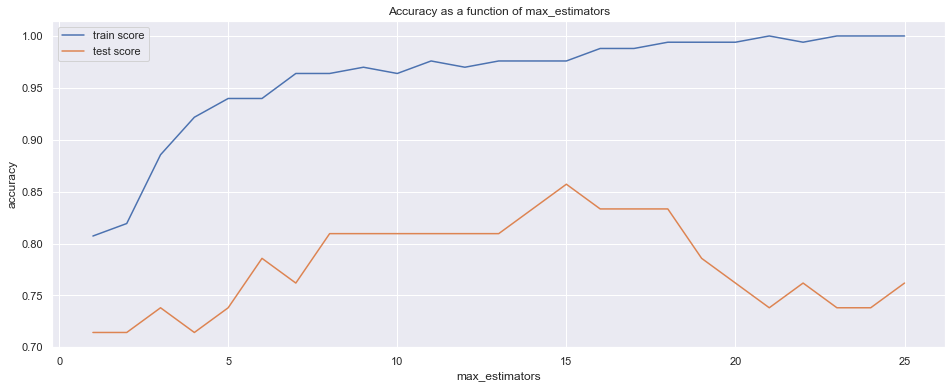

CPU times: total: 2min 13s
Wall time: 2min 26s


In [30]:
%%time
plot_metrics_on_estimators('gini')

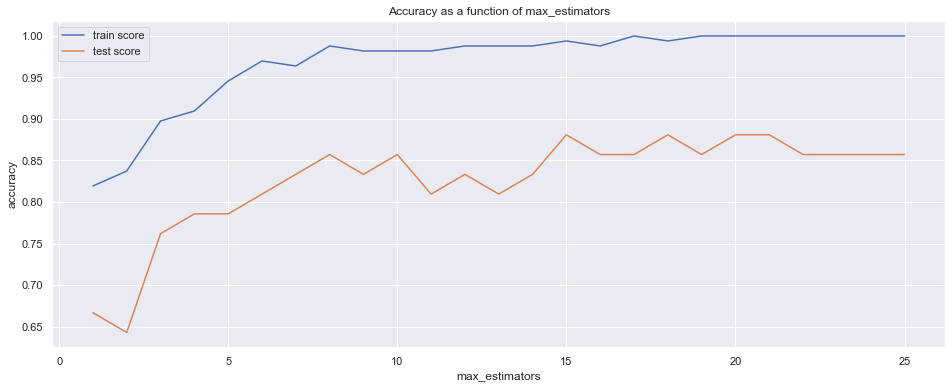

CPU times: total: 2min 17s
Wall time: 2min 25s


In [31]:
%%time
plot_metrics_on_estimators('entropy')

Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [32]:
# Your code here
# Сначала выделим 60% обучающего куска, а потом оставшиеся
# в тестовом 40% разобьём пополам в итоге получим 60%/20%/20%
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), 
                                                    df['target'], 
                                                    train_size=0.60, 
                                                    random_state=RANDOM_STATE
                                                   )

# В валидационную выборку отдаём 20 штук из оставшихся 80 (20% от общей выборки)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, 
                                                    y_test, 
                                                    test_size=0.5, 
                                                    random_state=RANDOM_STATE
                                                   )

print("Количество строк в наборах (X), шт.:", X_train.shape[0], X_valid.shape[0], X_test.shape[0])
print("Количество строк в наборах (y), шт.:", y_train.shape[0], y_valid.shape[0], y_test.shape[0])

Количество строк в наборах (X), шт.: 124 42 42
Количество строк в наборах (y), шт.: 124 42 42


In [33]:
# В задании говорится про выделение валидационной части.
# Но она ни где не используется.
# Если что, то эту ячейку можно раскомментировать.
# Здесть только обучающая и тестовая выборки.

# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), 
#                                                     df['target'], 
#                                                     train_size=0.60, 
#                                                     random_state=RANDOM_STATE
#                                                    )

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

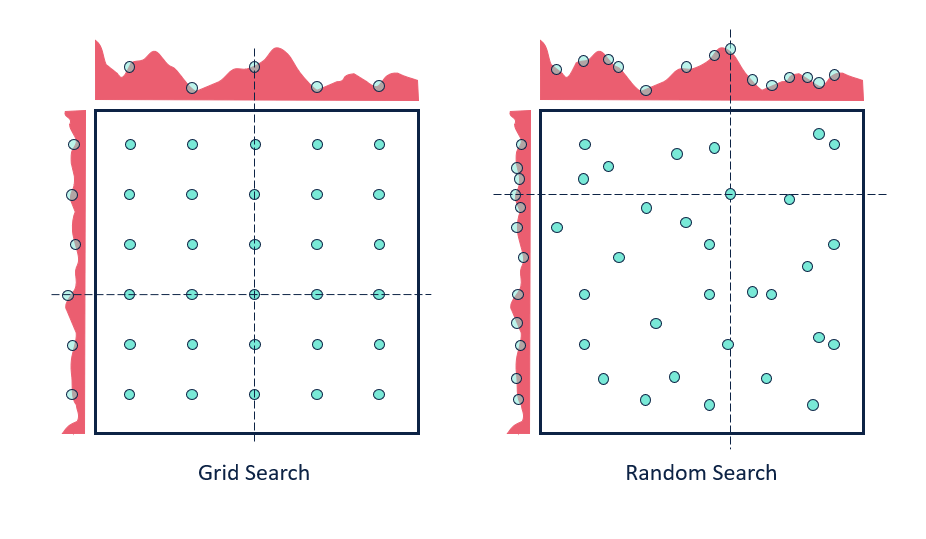

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [34]:
%%time
# Your code here
params = {"n_estimators": range(8, 10),
          "max_depth": range(3, 5),
          "feature_frac": [0.5],
          "feature_frac": [0.1, 0.5, 1],
          "criterion": ["entropy"],
          "bootstrap": [True],
          "random_gen": [np.random.default_rng(RANDOM_STATE)],
         }

rfс = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rfс, param_grid=params, cv=4, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Лучшие параметры подобранные на 'сетке': {grid_search.best_params_}\n")

model = RandomForestClassifier(**grid_search.best_params_)
model.fit(X_train.values, y_train.values)

train_score = round(accuracy_score(y_train, model.predict(X_train.values)), 3)
print(f"Оценка accuracy на обучающей выборке: {p('b',1)}{train_score}{p()}")

y_pred = model.predict(X_test.values)
test_score = round(accuracy_score(y_test, y_pred), 3)
print(f"Оценка accuracy на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

Лучшие параметры подобранные на 'сетке': {'bootstrap': True, 'criterion': 'entropy', 'feature_frac': 1, 'max_depth': 3, 'n_estimators': 8, 'random_gen': Generator(PCG64) at 0x1AB7FABED60}

Оценка accuracy на обучающей выборке: 0.935
Оценка accuracy на тестовой выборке:  0.619

CPU times: total: 26.8 s
Wall time: 3min 10s


**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [35]:
%%time
# Your code here
params = {"n_estimators": range(8, 10),
          "max_depth": range(3, 5),
          "feature_frac": [0.1, 0.5, 1],
          "criterion": ["entropy"],
          "bootstrap": [True],
          "random_gen": [np.random.default_rng(RANDOM_STATE)],
         }

rfс = RandomForestClassifier()
rfс_random = RandomizedSearchCV(estimator=rfс,
                                param_distributions=params,
                                n_iter=10,
                                random_state=RANDOM_STATE,
                                cv=4,
                                n_jobs=-1,
                               )

rfс_random.fit(X_train, y_train)
print(f"Лучшие параметры подобранные на 'сетке': {rfс_random.best_params_}\n")

model = RandomForestClassifier(**rfс_random.best_params_)
model.fit(X_train.values, y_train.values)

train_score = round(accuracy_score(y_train, model.predict(X_train.values)), 3)
print(f"Оценка accuracy на обучающей выборке: {p('b',1)}{train_score}{p()}")

y_pred = model.predict(X_test.values)
test_score = round(accuracy_score(y_test, y_pred), 3)
print(f"Оценка accuracy на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

Лучшие параметры подобранные на 'сетке': {'random_gen': Generator(PCG64) at 0x1AB00248C80, 'n_estimators': 8, 'max_depth': 4, 'feature_frac': 1, 'criterion': 'entropy', 'bootstrap': True}

Оценка accuracy на обучающей выборке: 0.992
Оценка accuracy на тестовой выборке:  0.548

CPU times: total: 37.6 s
Wall time: 3min 11s


**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

Your cool ideas here...

*****
### `ИТОГИ/ВЫВОДЫ`
Полученный опыт, конечно, небольшой, но что-то можно подчеркнуть из проделанных шагов по подобору параметров (`hyperparameter tuning`):
1. от каждого параметра в используемых методах ML может серьёзно зависеть результат как на обучающей так и на тестовой выборках;
1. подбор параметров требователен к вычислительным ресурсам;
1. фактически подбор параметров - это их перебор;
1. подбор "удачных" параметров, после шага, связанного с подготовкой данных, наверное, является самым времяёмким;
1. применение `GridSearchCV` упрощает код по перебору возможных комбинаций параметров для выбора наиболее удачного тюнинга модели, но несомненно является времяёмким процессом;
1. возможностью случайно "наткнуться" на лучший параметр, но несколько за более короткий промежуток времени является перебор параметров `RandomizedSearchCV`, использующего "случаные" поправки на "сетке" параметров;
1. одним из обязательных правил при подборе параметров является фиксация `random_state`, что позволяет обеспечить воспроизводитмость результатов экспериментов, без которых не возможно сделать хоть какие-то адекватные выводы;
1. инструментарий предоставляемый библиотекой `sklearn` обширен и позволяет использовать её средства с "самописными" решателями;
1. увеличение количества деревье в "случайном лесе" приводит к результату, напоминающему переобучение - модель хорошо работает на обучающей выборке, но на тестовой выборке результат начинает ухудшаться;
1. всё больше и больше технологии машинного обучения отдаляются от научно-объяснимых методов и приближаются если не к шаманским техникам Вуду, то уж к рутинным последовательным операциям, иногда, приводимым к плохообъяснимым результатам, например, в этой работе с использованием самописного алгоритма "случайного леса" мы:
* просто установив `n_estimators=10` и выбором одного из двух критерие в пользу `entropy` потратили приблизительно 3 (три) секунды и получили на обучающей выборке **`accuracy=0.982`**, а на тестовой **`accuracy=0.857`**;
* просто поменяв `n_estimators=100` потратили приблизительно 30 (тридцать) секунд и получили на обучающей выборке **`accuracy=1.00`**, а на тестовой **`accuracy=0.881`**
* использовав `GridSearchCV` на небольшой "сетке" пераметров уже почти через 3 (три) минуты получили следующие результаты: на обучающей выборке **`accuracy=0.94`**, а на тестовой **`accuracy=0.62`**
* использовав `RandomizedSearchCV` на той же "сетке" пераметров за 2,5 (две с половиной) минуты получили на обучающей выборке **`accuracy=0.99`**, а на тестовой **`accuracy=0.55`**
* потратили суммарно на все из описанных выше вариантов около 3-х часов (написание кода; исправление ошибок; уточнение сетки, чтобы она не была слишком большой и долго обрабатывалась), тогда как "тупой" способ увеличения количества деревьев до 100 за 5 минут суммарно потраченного на него времени дал лучший результат (если работа ML-инженера состоит в том чтобы ждать пока его модель обсчитается по всем возможным вариантам на "сетке" параметров, то это **лучшая работа в мире**, так как сразу возникает мысль выставить максимально разнобразные варианты и идти домой спать, а через неделю вернуться и посмотреть на результат).

*****


### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [36]:
# your code here
PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### Немного пофичеинженирим:
Но не будим на них особенно сильно тратить время - тут главное алгоритм протестировать.

In [37]:
# Посмотрим проценты пропусков в данных по столбцам:
missing_values = ((data.isna().sum() / data.shape[0]) * 100 ).sort_values(ascending=False)
print("-------------------------------")
print("Процент пропущенных значений:")
print(missing_values)
print("-------------------------------")
missing_values = data.isna().sum().sort_values(ascending=False)
print("Количество пропущенных значений:")
print(missing_values)
print("-------------------------------")


-------------------------------
Процент пропущенных значений:
Cabin       67.866
Ticket       4.623
Age          3.292
Embarked     0.250
Fare         0.134
Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
SibSp        0.000
Parch        0.000
dtype: float64
-------------------------------
Количество пропущенных значений:
Cabin       67866
Ticket       4623
Age          3292
Embarked      250
Fare          134
Survived        0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
dtype: int64
-------------------------------


In [38]:
# Посмотрис какие параметря у нас не числовые
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [39]:
data_prep = data.copy(deep=True)

data_prep["Cabin_missed"] = data_prep["Cabin"].isna() * 1
data_prep["Cabin"] = data_prep["Cabin"].fillna("НетКаюты")

data_prep["Ticket_missed"] = data_prep["Ticket"].isna() * 1
data_prep["Ticket"] = data_prep["Ticket"].fillna("НетБилета")

data_prep["Age_missed"] = data_prep["Age"].isna() * 1
n_age_mean = data_prep["Age"].mean()
data_prep["Age"] = data_prep["Age"].fillna(n_age_mean)

data_prep["Embarked_missed"] = data_prep["Embarked"].isna() * 1
data_prep["Embarked"] = data_prep["Embarked"].fillna("S")

data_prep["Fare_missed"] = data_prep["Fare"].isna() * 1
n_fate_mean = data_prep["Fare"].mean()
data_prep["Fare"] = data_prep["Fare"].fillna(n_fate_mean)

data_prep["Sex"] = data_prep["Sex"].map({"male": 1, "female": 0})

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_prep[["Embarked"]])
data_prep[ohe.get_feature_names_out()] = ohe.transform(data_prep[["Embarked"]])

del data_prep["Cabin"]
del data_prep["Ticket"]
del data_prep["Name"]
del data_prep["Embarked"]

data_prep.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_missed,Ticket_missed,Age_missed,Embarked_missed,Fare_missed,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
0,1,1,1,38.355472,2,0,27.14,0,0,1,0,0,0.0,0.0,1.0
1,0,3,1,38.355472,0,0,13.35,1,0,1,0,0,0.0,0.0,1.0
2,0,3,1,0.330000,1,2,71.29,1,0,0,0,0,0.0,0.0,1.0
3,0,3,1,19.000000,0,0,13.04,1,0,0,0,0,0.0,0.0,1.0
4,1,3,1,25.000000,0,0,7.76,1,0,0,0,0,0.0,0.0,1.0
5,0,2,1,35.000000,0,0,6.71,1,0,0,0,0,0.0,0.0,1.0
6,0,3,1,7.000000,0,0,9.77,1,0,0,0,0,0.0,0.0,1.0
7,1,3,0,6.000000,1,2,31.50,1,0,0,0,0,0.0,0.0,1.0
8,0,1,1,27.000000,2,1,73.02,0,0,0,0,0,0.0,0.0,1.0


In [40]:
X_train, X_test, y_train, y_test = \
                            train_test_split(data_prep.drop(columns='Survived'), 
                                             data_prep['Survived'], 
                                             train_size=0.70, 
                                             random_state=RANDOM_STATE
                                            )

print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

70000 30000 70000 30000


In [41]:
%%time
params = {   
            'ccp_alpha': [x / 10 for x in range(1, 5)],
            'class_weight': [{0: x / 10, 1: round(1 - x / 10, 1)} for x in range(1, 5)],
            'criterion': ['gini'],
#             'max_depth': [x for x in range(1, 10)],
            'splitter': ['best']
         }

dtc = DecisionTreeClassifier()
dtc_random = RandomizedSearchCV(estimator=dtc,
                                param_distributions=params,
                                n_iter=5,
                                random_state=RANDOM_STATE,
                                n_jobs=-1,
                               )

dtc_random.fit(X_train, y_train)
print(f"Лучшие параметры подобранные на 'сетке': {dtc_random.best_params_}\n")

model = DecisionTreeClassifier(**dtc_random.best_params_)
model.fit(X_train.values, y_train.values)

train_score = round(accuracy_score(y_train, model.predict(X_train.values)), 3)
print(f"Оценка accuracy на обучающей выборке: {p('b',1)}{train_score}{p()}")

y_pred = model.predict(X_test.values)
test_score = round(accuracy_score(y_test, y_pred), 3)
print(f"Оценка accuracy на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

Лучшие параметры подобранные на 'сетке': {'splitter': 'best', 'criterion': 'gini', 'class_weight': {0: 0.3, 1: 0.7}, 'ccp_alpha': 0.1}

Оценка accuracy на обучающей выборке: 0.757
Оценка accuracy на тестовой выборке:  0.761

CPU times: total: 3.59 s
Wall time: 27.2 s


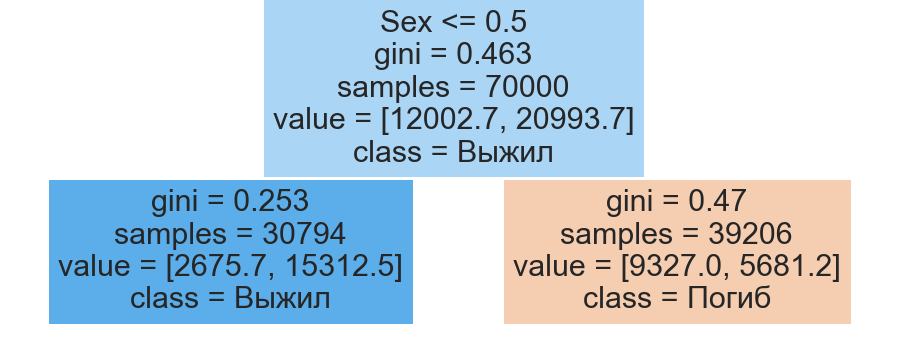

In [42]:
tree.plot_tree(model,
               feature_names=data_prep.drop(columns='Survived').columns,
               class_names=["Погиб", "Выжил"],
               filled=True
              )
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?

*****
### `КОММЕНТАРИЙ`
>Какая-то странная ситуация, в дереве только одно ветвление, но требование выполнено: **`test accuracy more than 0.65`**
>
>Проверим, а на самом ли деле одно это даст такое accuracy? **Сделаем предсказание в ручную по этим данным и рассчитаем accuracy**.
*****


In [43]:
y_predict_by_hand = (X_train.Sex == 0) * 1
train_score = round(accuracy_score(y_train, y_predict_by_hand), 3)
print(f"Оценка accuracy на обучающей выборке: {p('b',1)}{train_score}{p()}")

y_predict_by_hand = (X_test.Sex == 0) * 1
test_score = round(accuracy_score(y_test, y_predict_by_hand), 3)
print(f"Оценка accuracy на тестовой выборке:  {p('r',1)}{test_score}{p()}\n")

Оценка accuracy на обучающей выборке: 0.757
Оценка accuracy на тестовой выборке:  0.761



*****
### `КОММЕНТАРИЙ`
>И, действительно, исходя из этого очень просто достаточно достоверно предсказать выживаемость человека на Титанике, всего лишь, посмотрев на его пол в паспорте! ... но это только если этот человек **не** житель Европы или США, так как в случае с последними могут возникнуть сложности с половой идентификацией по данным паспорта ...
*****
